#  Flight Delay Prediction with Explainable AI and Operational Adjustability
This notebook presents an end-to-end analysis and predictive modeling of flight delays using historical airline data.
Goals:
- Understand delay patterns
- Predict likelihood and duration of delays
- Highlight controllable causes using SHAP and OAI


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve)
import shap

In [ ]:

df = pd.read_csv("Airline_Delay_Cause.csv")
df.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,12,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",72.0,5.0,2.46,1.00,...,0.0,0.81,0.0,0.0,672.0,61.0,574.0,20.0,0.0,17.0
1,2023,12,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,7.0,4.25,0.00,...,0.0,1.75,0.0,0.0,348.0,252.0,0.0,33.0,0.0,63.0
2,2023,12,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",95.0,10.0,5.94,0.00,...,0.0,3.00,0.0,0.0,859.0,536.0,0.0,47.0,0.0,276.0
3,2023,12,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",23.0,2.0,0.56,0.00,...,0.0,1.44,1.0,0.0,75.0,9.0,0.0,0.0,0.0,66.0
4,2023,12,9E,Endeavor Air Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",2111.0,256.0,76.88,8.75,...,0.0,117.94,1.0,0.0,21424.0,8906.0,732.0,1487.0,0.0,10299.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179338 entries, 0 to 179337
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 179338 non-null  int64  
 1   month                179338 non-null  int64  
 2   carrier              179338 non-null  object 
 3   carrier_name         179338 non-null  object 
 4   airport              179338 non-null  object 
 5   airport_name         179338 non-null  object 
 6   arr_flights          178997 non-null  float64
 7   arr_del15            178747 non-null  float64
 8   carrier_ct           178997 non-null  float64
 9   weather_ct           178997 non-null  float64
 10  nas_ct               178997 non-null  float64
 11  security_ct          178997 non-null  float64
 12  late_aircraft_ct     178997 non-null  float64
 13  arr_cancelled        178997 non-null  float64
 14  arr_diverted         178997 non-null  float64
 15  arr_delay        

In [ ]:
df.isnull().sum()

,0
year,0
month,0
carrier,0
carrier_name,0
airport,0
airport_name,0
arr_flights,341
arr_del15,591
carrier_ct,341
weather_ct,341


Since very less amount of data were null so i droped it

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

,0
year,0
month,0
carrier,0
carrier_name,0
airport,0
airport_name,0
arr_flights,0
arr_del15,0
carrier_ct,0
weather_ct,0


In [ ]:
df.columns

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

#EDA

In [ ]:
df.describe()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000,178747.000000
mean,2019.478604,6.488411,328.263244,58.709086,18.598619,2.038589,17.118839,0.145511,20.807539,6.827555,0.780545,3868.713998,1327.400141,209.405898,821.096086,6.849508,1503.955406
std,2.412093,3.464885,931.575550,164.378035,47.417686,6.899212,56.315314,0.702619,64.953490,41.471159,3.492814,11909.596123,4070.328372,792.332527,3180.677510,40.467958,4881.265039
min,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,41.000000,6.000000,1.970000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,290.000000,91.000000,0.000000,28.000000,0.000000,55.000000
50%,2020.000000,6.000000,89.000000,15.000000,5.420000,0.220000,3.310000,0.000000,4.300000,1.000000,0.000000,903.000000,322.000000,12.000000,124.000000,0.000000,287.000000
75%,2022.000000,10.000000,218.000000,40.000000,14.730000,1.630000,9.880000,0.000000,13.040000,3.000000,1.000000,2552.000000,988.000000,131.000000,401.500000,0.000000,966.000000
max,2023.000000,12.000000,21977.000000,4176.000000,1293.910000,266.420000,1884.420000,58.690000,2069.070000,4951.000000,160.000000,438783.000000,196944.000000,31960.000000,112018.000000,3760.000000,227959.000000


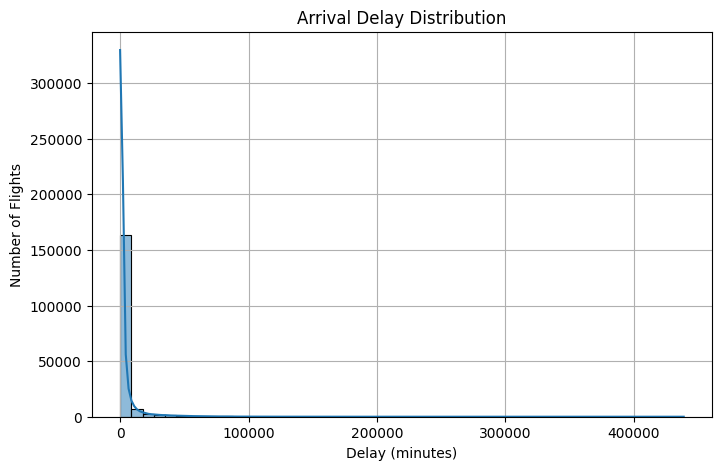

Delayed flights (>15 min): 170036
On-time or minor delay (<=15 min): 8711


In [ ]:

plt.figure(figsize=(8,5))
sns.histplot(df['arr_delay'], bins=50, kde=True)
plt.title("Arrival Delay Distribution")
plt.xlabel("Delay (minutes)")
plt.ylabel("Number of Flights")
plt.grid(True)
plt.show()


print("Delayed flights (>15 min):", (df['arr_delay'] > 15).sum())
print("On-time or minor delay (<=15 min):", (df['arr_delay'] <= 15).sum())


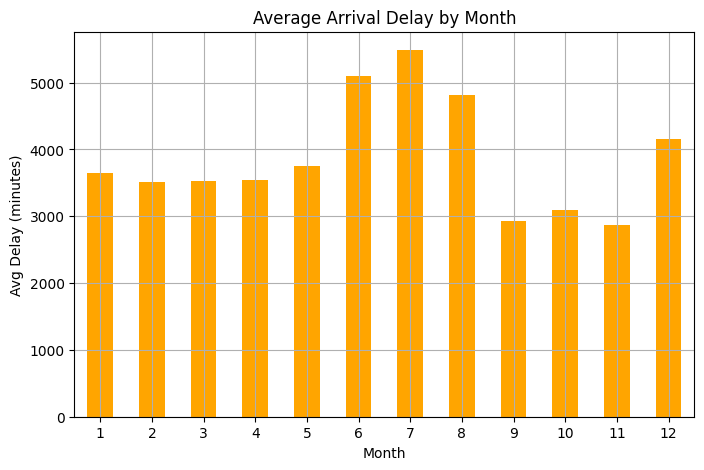

In [ ]:

monthly_delay = df.groupby('month')['arr_delay'].mean()

plt.figure(figsize=(8,5))
monthly_delay.plot(kind='bar', color='orange')
plt.title("Average Arrival Delay by Month")
plt.xlabel("Month")
plt.ylabel("Avg Delay (minutes)")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


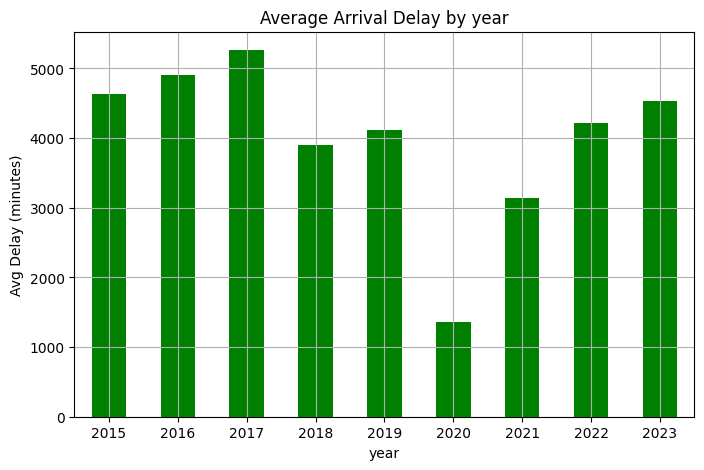

In [ ]:
yearly_delay = df.groupby('year')['arr_delay'].mean()

plt.figure(figsize=(8,5))
yearly_delay.plot(kind='bar', color='green')
plt.title("Average Arrival Delay by year")
plt.xlabel("year")
plt.ylabel("Avg Delay (minutes)")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

<ipython-input-15-eea855e40ad8>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cause_totals.keys()), y=list(cause_totals.values()), palette="Set2")


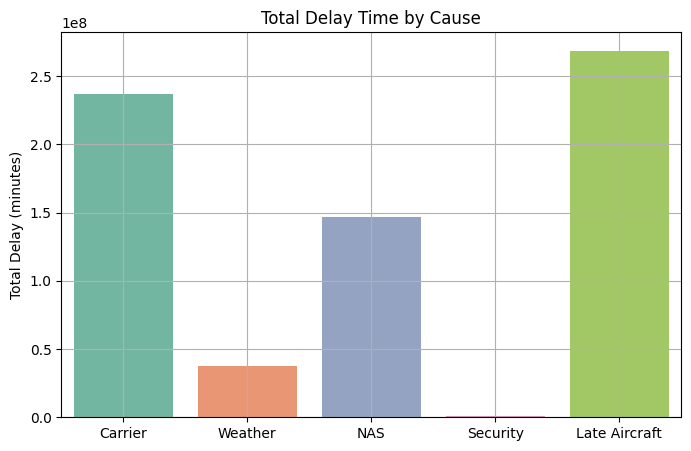

In [ ]:
cause_totals = {
    'Carrier': df['carrier_delay'].sum(),
    'Weather': df['weather_delay'].sum(),
    'NAS': df['nas_delay'].sum(),
    'Security': df['security_delay'].sum(),
    'Late Aircraft': df['late_aircraft_delay'].sum()
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(cause_totals.keys()), y=list(cause_totals.values()), palette="Set2")
plt.title("Total Delay Time by Cause")
plt.ylabel("Total Delay (minutes)")
plt.grid(True)
plt.show()


The bar chart clearly highlights that "Late Aircraft" and "Carrier" delays are the most dominant contributors to total flight delay time, significantly outweighing other causes such as NAS, Weather, and Security.

<ipython-input-16-bd2e61f99fa1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_airports.values, y=top_airports.index, palette="magma")


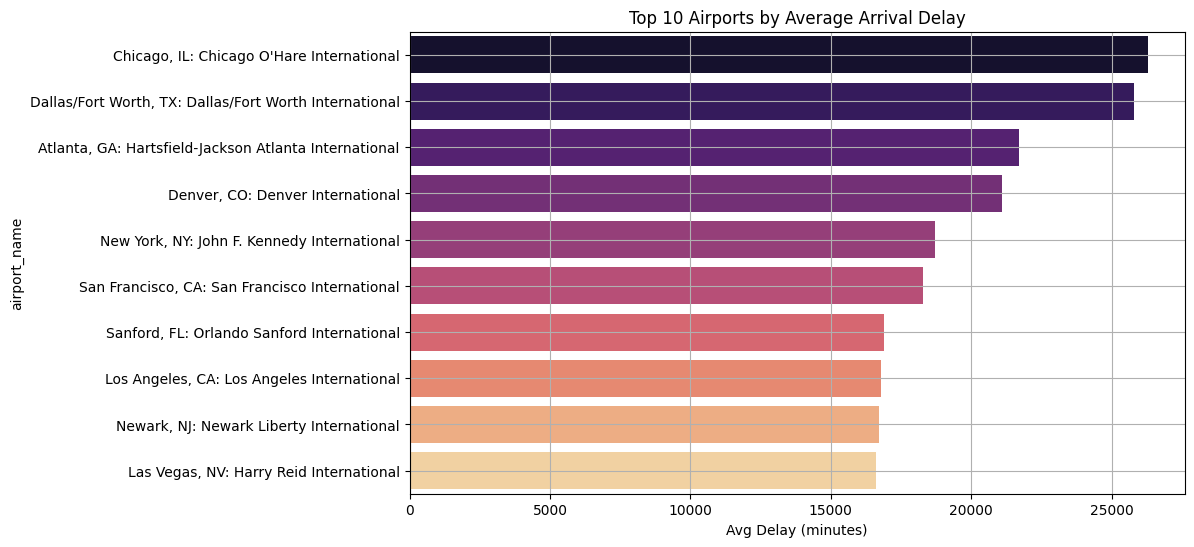

In [ ]:
top_airports = df.groupby('airport_name')['arr_delay'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_airports.values, y=top_airports.index, palette="magma")
plt.title("Top 10 Airports by Average Arrival Delay")
plt.xlabel("Avg Delay (minutes)")
plt.grid(True)
plt.show()


It will not cause significant change in delay since all airport bar graph is almost equal

<ipython-input-17-526a7380c678>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=carrier_delay_rate.values, y=carrier_delay_rate.index, palette="coolwarm")


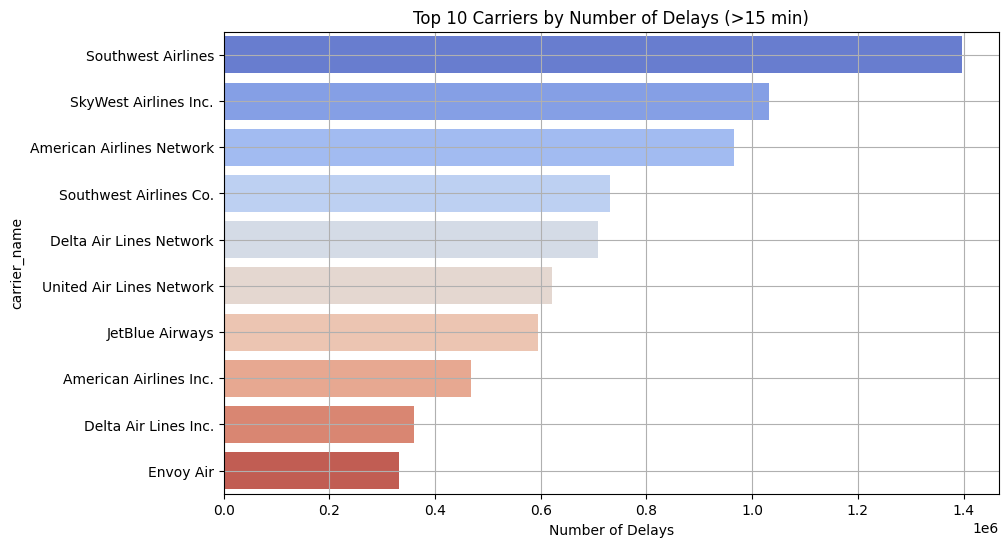

In [ ]:
carrier_delay_rate = df.groupby('carrier_name')['arr_del15'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=carrier_delay_rate.values, y=carrier_delay_rate.index, palette="coolwarm")
plt.title("Top 10 Carriers by Number of Delays (>15 min)")
plt.xlabel("Number of Delays")
plt.grid(True)
plt.show()


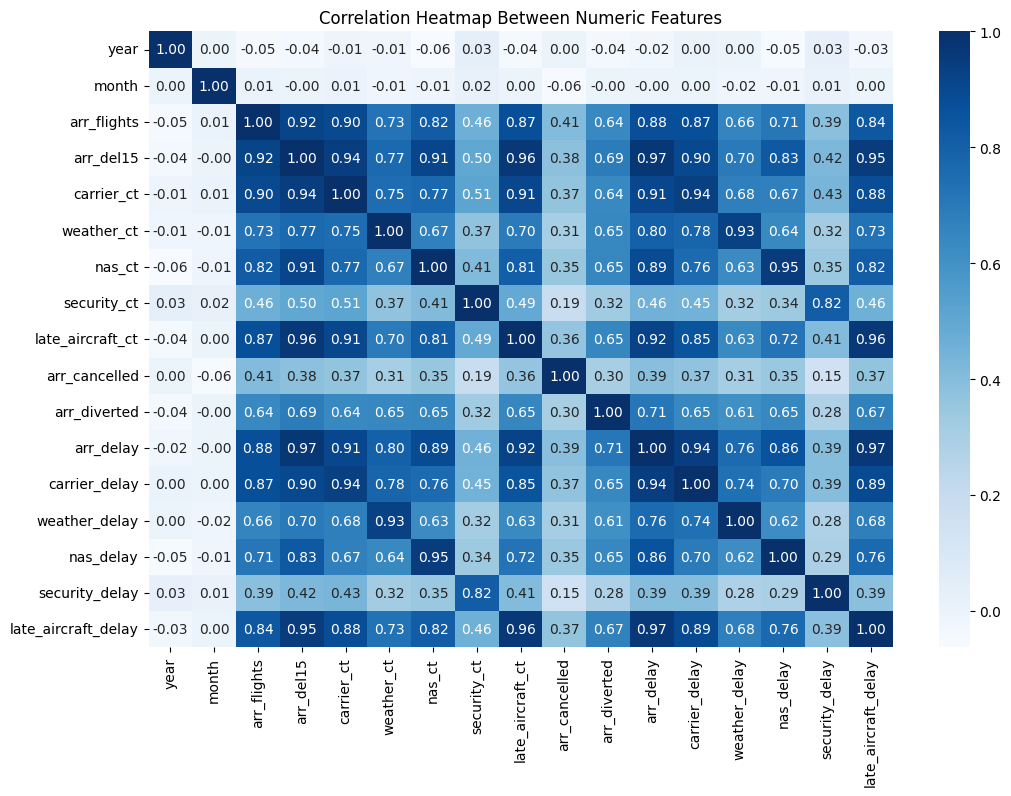

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap Between Numeric Features")
plt.show()


#FEATURE ENGINEERING

In [ ]:

df['is_delayed'] = (df['arr_delay'] > 15).astype(int)




<Axes: xlabel='is_delayed'>

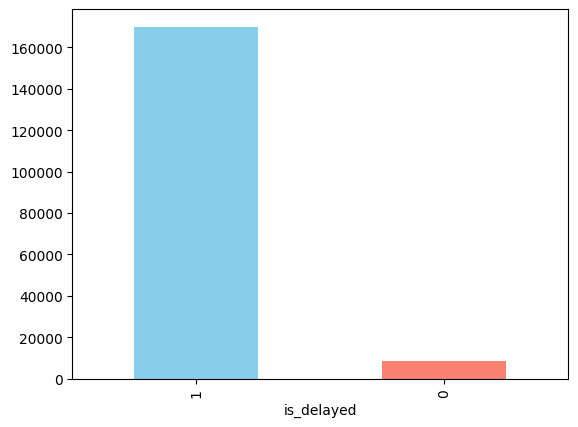

In [ ]:
df['is_delayed'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

One Hot Encoding

In [ ]:
df_encoded = pd.get_dummies(df, columns=['carrier', 'airport'], drop_first=True)


In [ ]:
drop_cols = ['carrier_name', 'airport_name', 'date', 'day', 'day_of_week']
df_model = df_encoded.drop(columns=drop_cols, errors='ignore')


#Model Building

In [ ]:
from sklearn.model_selection import train_test_split

X_clf = df_model.drop(columns=['arr_delay', 'is_delayed'])
y_clf = df_model['is_delayed']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)


In [ ]:
X_reg = df_model.drop(columns=['arr_delay', 'is_delayed'])
y_reg = df_model['arr_delay']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train_clf, y_train_clf)
y_pred_log = log_clf.predict(X_test_clf)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1706
           1       1.00      1.00      1.00     34044

    accuracy                           1.00     35750
   macro avg       1.00      1.00      1.00     35750
weighted avg       1.00      1.00      1.00     35750



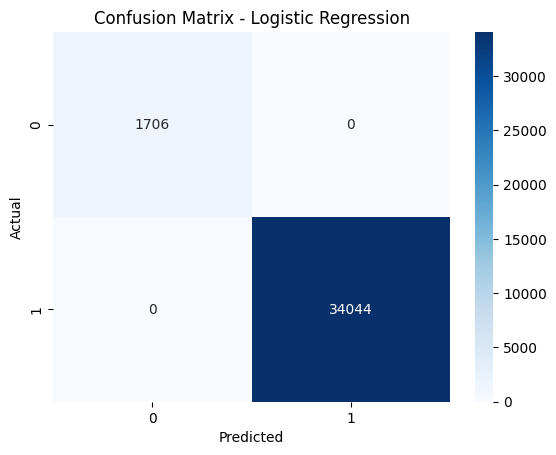

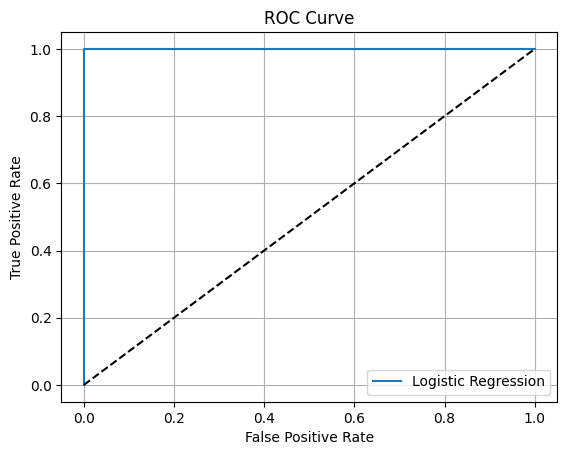

ROC AUC Score: 1.0


In [ ]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test_clf, y_pred_log))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
y_prob_log = log_clf.predict_proba(X_test_clf)[:,1]
fpr, tpr, _ = roc_curve(y_test_clf, y_prob_log)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

print("ROC AUC Score:", roc_auc_score(y_test_clf, y_prob_log))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1706
           1       1.00      1.00      1.00     34044

    accuracy                           1.00     35750
   macro avg       1.00      0.99      0.99     35750
weighted avg       1.00      1.00      1.00     35750



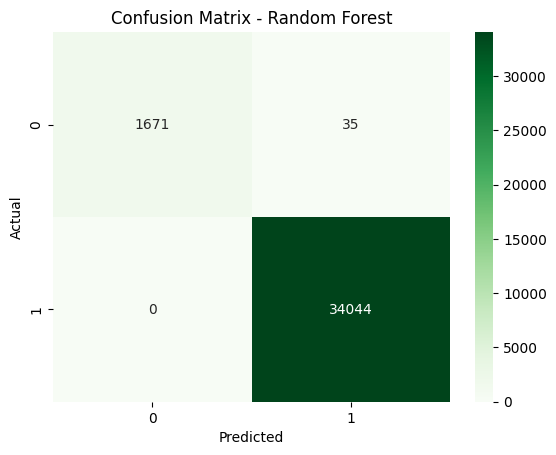

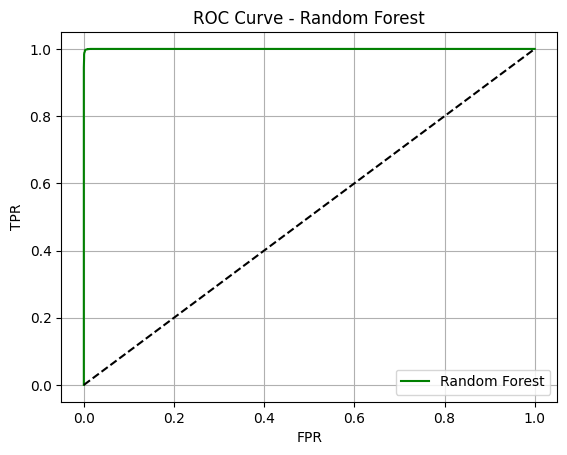

ROC AUC Score (RF): 0.9999414418937606


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)
y_pred_rf = rf_clf.predict(X_test_clf)

print("Random Forest Classification Report:")
print(classification_report(y_test_clf, y_pred_rf))


cm_rf = confusion_matrix(y_test_clf, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


y_prob_rf = rf_clf.predict_proba(X_test_clf)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_clf, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label='Random Forest', color='green')
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

print("ROC AUC Score (RF):", roc_auc_score(y_test_clf, y_prob_rf))


In [ ]:
leakage_features = [
    'arr_del15', 'arr_delay', 'carrier_delay', 'weather_delay',
    'nas_delay', 'security_delay', 'late_aircraft_delay',
    'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct'
]

X = df_model.drop(columns=leakage_features + ['is_delayed'], errors='ignore')
y = df_model['is_delayed']

from sklearn.model_selection import train_test_split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
log_clf = LogisticRegression(max_iter=1000, class_weight='balanced')
log_clf.fit(X_train_clf, y_train_clf)
y_pred_log = log_clf.predict(X_test_clf)

print(classification_report(y_test_clf, y_pred_log))


              precision    recall  f1-score   support

           0       0.24      0.94      0.38      1706
           1       1.00      0.85      0.92     34044

    accuracy                           0.85     35750
   macro avg       0.62      0.89      0.65     35750
weighted avg       0.96      0.85      0.89     35750



In [ ]:
print(confusion_matrix(y_test_clf, y_pred_log))

[[ 1607    99]
 [ 5216 28828]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)
y_pred_rf = rf_clf.predict(X_test_clf)

print("Random Forest:\n", classification_report(y_test_clf, y_pred_rf))


Random Forest:
               precision    recall  f1-score   support

           0       0.62      0.46      0.53      1706
           1       0.97      0.99      0.98     34044

    accuracy                           0.96     35750
   macro avg       0.80      0.72      0.76     35750
weighted avg       0.96      0.96      0.96     35750



In [ ]:
print(confusion_matrix(y_test_clf, y_pred_rf))

[[  789   917]
 [  477 33567]]


In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train_clf[y_train_clf == 0]) / len(y_train_clf[y_train_clf == 1])))
xgb_clf.fit(X_train_clf, y_train_clf)
y_pred_xgb = xgb_clf.predict(X_test_clf)

print("XGBoost:\n", classification_report(y_test_clf, y_pred_xgb))


XGBoost:
               precision    recall  f1-score   support

           0       0.32      0.92      0.48      1706
           1       1.00      0.90      0.95     34044

    accuracy                           0.90     35750
   macro avg       0.66      0.91      0.71     35750
weighted avg       0.96      0.90      0.93     35750



In [ ]:
print(confusion_matrix(y_test_clf, y_pred_xgb))

[[ 1562   144]
 [ 3271 30773]]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_clf, y_train_clf)
y_pred_gb = gb_clf.predict(X_test_clf)

print("Gradient Boosting:\n", classification_report(y_test_clf, y_pred_gb))


Gradient Boosting:
               precision    recall  f1-score   support

           0       0.68      0.50      0.58      1706
           1       0.98      0.99      0.98     34044

    accuracy                           0.96     35750
   macro avg       0.83      0.75      0.78     35750
weighted avg       0.96      0.96      0.96     35750



In [ ]:
print(confusion_matrix(y_test_clf, y_pred_gb))

[[  858   848]
 [  405 33639]]


In [ ]:
!pip install shap


In [ ]:
import shap
import xgboost
import matplotlib.pyplot as plt


explainer = shap.Explainer(xgb_clf)

shap_values = explainer(X_test_clf)


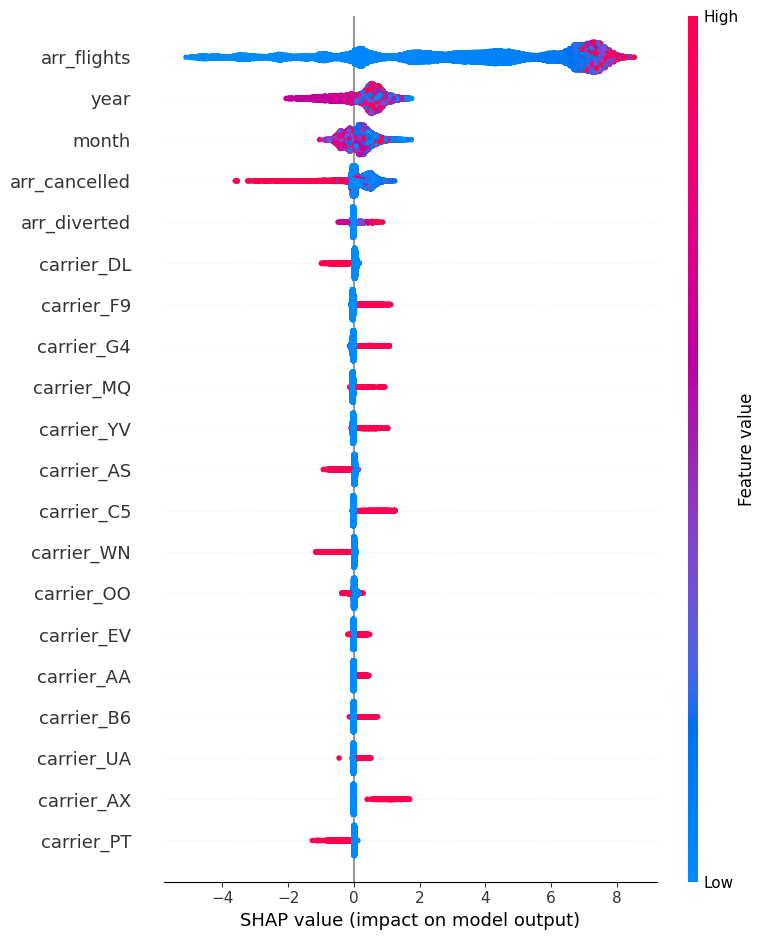

In [ ]:

shap.summary_plot(shap_values, X_test_clf)


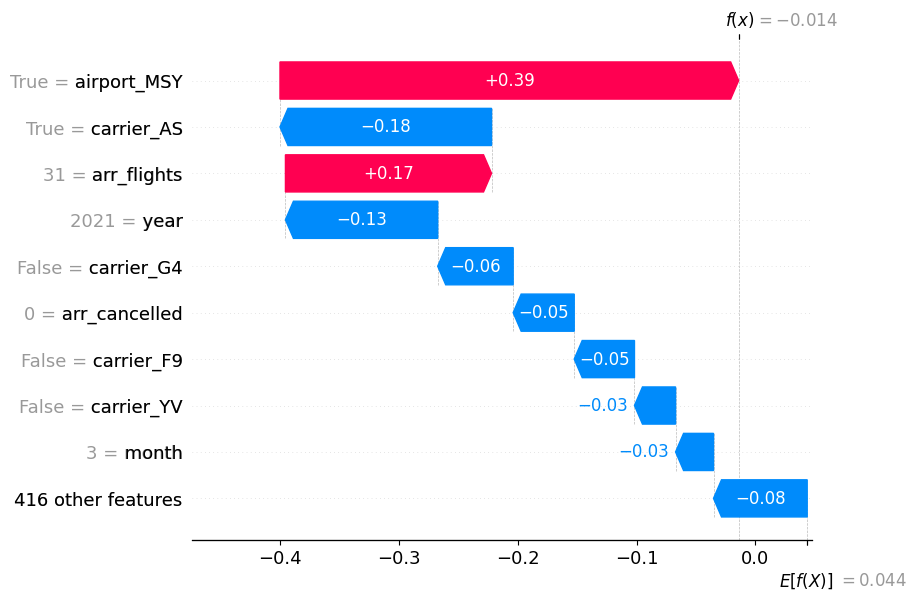

In [ ]:

i = 10
shap.plots.waterfall(shap_values[i])


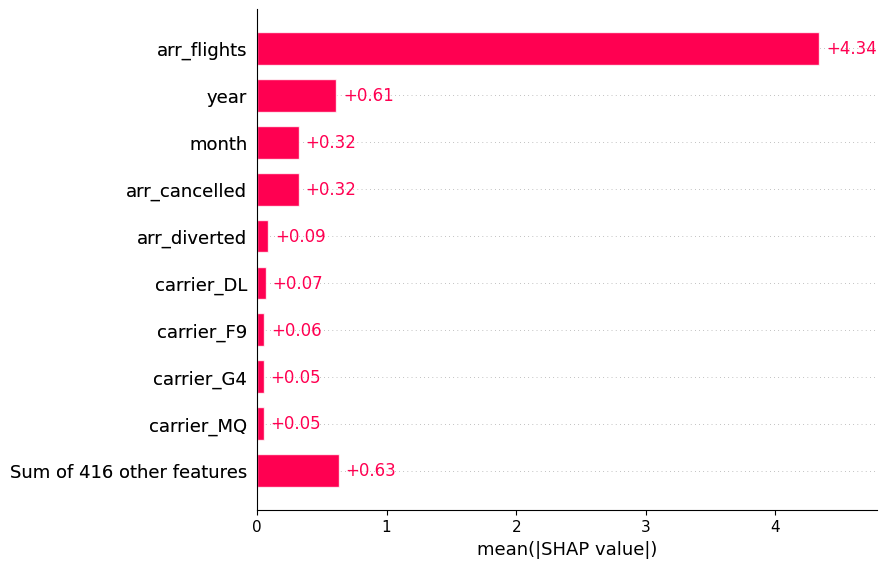

In [ ]:
shap.plots.bar(shap_values)


#OAI

count    178747.000000
mean          0.703394
std           0.260500
min           0.000000
25%           0.608342
50%           0.775006
75%           0.884115
max           1.000000
Name: oai, dtype: float64


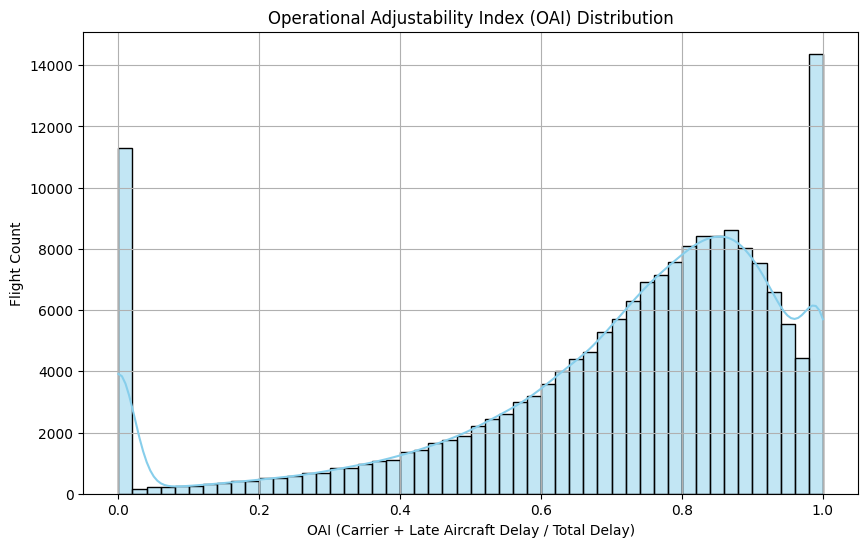

In [ ]:

df['oai'] = (df['carrier_delay'] + df['late_aircraft_delay']) / df['arr_delay']

df['oai'] = df['oai'].replace([np.inf, -np.inf], np.nan)
df['oai'] = df['oai'].fillna(0)

print(df['oai'].describe())


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(df['oai'], bins=50, kde=True, color='skyblue')
plt.title("Operational Adjustability Index (OAI) Distribution")
plt.xlabel("OAI (Carrier + Late Aircraft Delay / Total Delay)")
plt.ylabel("Flight Count")
plt.grid(True)
plt.show()


Average OAI per carrier

carrier_name
Hawaiian Airlines Inc.                       0.947064
Hawaiian Airlines Network                    0.943989
Empire Airlines Inc.                         0.900038
Southwest Airlines                           0.842102
Southwest Airlines Co.                       0.838280
Cape Air                                     0.823497
American Airlines Network                    0.775310
Compass Airlines                             0.764403
SkyWest Airlines Inc.                        0.759744
JetBlue Airways                              0.749042
United Air Lines Inc.                        0.748227
Trans States Airlines                        0.742873
American Airlines Inc.                       0.739639
ExpressJet Airlines Inc.                     0.731339
Peninsula Airways Inc.                       0.725350
United Air Lines Network                     0.723374
Delta Air Lines Network                      0.722184
Horizon Air                                  0.713804
Mesa Airlines I

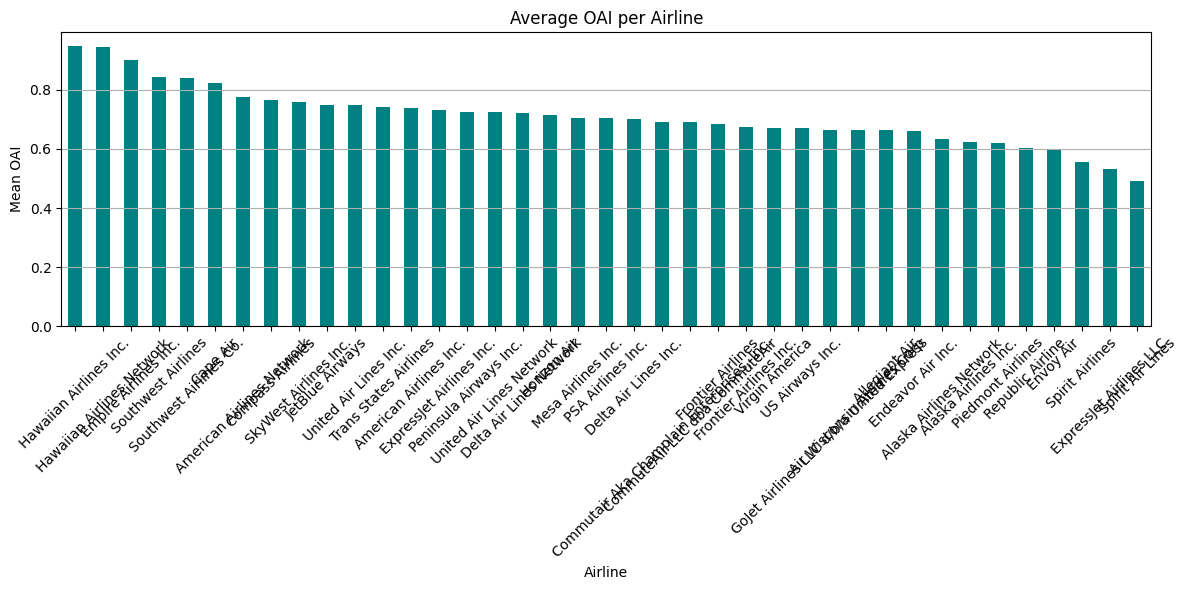

In [ ]:

carrier_oai = df.groupby('carrier_name')['oai'].mean().sort_values(ascending=False)
print(carrier_oai)


plt.figure(figsize=(12,6))
carrier_oai.plot(kind='bar', color='teal')
plt.title("Average OAI per Airline")
plt.ylabel("Mean OAI")
plt.xlabel("Airline")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


Since the above model did not give better f2 score , so i tried with some feature selection technique

In [ ]:
df.shape

(178747, 21)

In [ ]:
df.columns

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

In [ ]:
df['year'].value_counts()

,count
year,
2019,25823
2018,24921
2022,22929
2021,22756
2023,22569
2020,21538
2015,13513
2017,12503
2016,12195


In [ ]:
df['arr_del15'].value_counts()

,count
arr_del15,
0.0,8373
1.0,8027
2.0,7424
3.0,7019
4.0,6959
...,...
1468.0,1
1777.0,1
1378.0,1


In [ ]:
delay =[]
for row in df['arr_delay']:
    if row > 60:
        delay.append(3)
    elif row > 30:
        delay.append(2)
    elif row > 15:
        delay.append(1)
    else:
        delay.append(0)
df['delay'] = delay

4 different output category

In [ ]:
df['delay'].value_counts()

,count
delay,
3,162407
0,8711
2,4612
1,3017


In [ ]:
df['arr_delay'].value_counts()

,count
arr_delay,
0.0,8373
15.0,338
17.0,318
16.0,297
18.0,274
...,...
16458.0,1
13033.0,1
23248.0,1


In [ ]:
df['month'].value_counts()

,count
month,
1,15224
3,15187
12,15090
2,14970
6,14930
8,14864
9,14861
11,14830
10,14783


In [ ]:
df.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,delay
0,2023,12,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",72.0,5.0,2.46,1.00,...,0.81,0.0,0.0,672.0,61.0,574.0,20.0,0.0,17.0,3
1,2023,12,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,7.0,4.25,0.00,...,1.75,0.0,0.0,348.0,252.0,0.0,33.0,0.0,63.0,3
2,2023,12,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",95.0,10.0,5.94,0.00,...,3.00,0.0,0.0,859.0,536.0,0.0,47.0,0.0,276.0,3
3,2023,12,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",23.0,2.0,0.56,0.00,...,1.44,1.0,0.0,75.0,9.0,0.0,0.0,0.0,66.0,3
4,2023,12,9E,Endeavor Air Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",2111.0,256.0,76.88,8.75,...,117.94,1.0,0.0,21424.0,8906.0,732.0,1487.0,0.0,10299.0,3


some leakage features

In [ ]:
leakage_features = [
    'arr_del15', 'arr_delay', 'arr_cancelled','airport', 'carrier', 'carrier_name', 'airport_name',
    'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct','arr_flights'
]

In [ ]:
df_val=df.drop(columns=leakage_features, axis=1)

In [ ]:
df_val.shape

(178747, 9)

In [ ]:
df_val.head()

,year,month,arr_diverted,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,delay
0,2023,12,0.0,61.0,574.0,20.0,0.0,17.0,3
1,2023,12,0.0,252.0,0.0,33.0,0.0,63.0,3
2,2023,12,0.0,536.0,0.0,47.0,0.0,276.0,3
3,2023,12,0.0,9.0,0.0,0.0,0.0,66.0,3
4,2023,12,0.0,8906.0,732.0,1487.0,0.0,10299.0,3


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
data = df_val.values
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
scaled_features = StandardScaler().fit_transform(X_train, X_test)

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class='ovr')
auc_score

np.float64(0.9856163180146367)

In [ ]:
accuracy_score(y_test, y_pred)

0.9965687645687645

In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 2582,    13,     0,     0],
       [   16,   890,    23,     0],
       [    2,    22,  1335,    52],
       [    0,     2,    54, 48634]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2595
         1.0       0.94      0.97      0.95       929
         2.0       0.97      0.94      0.95      1411
         3.0       1.00      1.00      1.00     48690

    accuracy                           1.00     53625
   macro avg       0.97      0.98      0.97     53625
weighted avg       1.00      1.00      1.00     53625



In [ ]:
confusion_matrix(y_test, y_pred_rf)

array([[ 2564,    31,     0,     0],
       [    5,   902,    22,     0],
       [    2,    28,  1329,    52],
       [    0,     0,    26, 48664]])

In [ ]:
accuracy_score(y_test, y_pred_rf)

0.9969044289044289

after applying this feature selection technique the performance significantly improved

In [ ]:
delay =[]
for row in df['arr_delay']:
    if row > 30:
        delay.append(1)

    else:
        delay.append(0)
df['delay'] = delay

again tried with 2 different output category

In [ ]:
df['delay'].value_counts()

,count
delay,
1,167019
0,11728


In [ ]:
df_val=df.drop(columns=leakage_features, axis=1)

In [ ]:
data = df_val.values
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
scaled_features = StandardScaler().fit_transform(X_train, X_test)

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3524
         1.0       1.00      1.00      1.00     50101

    accuracy                           1.00     53625
   macro avg       1.00      1.00      1.00     53625
weighted avg       1.00      1.00      1.00     53625



this also give extraordinary result

In [ ]:
accuracy_score(y_test, y_pred_rf)

0.9994032634032634

In [ ]:
confusion_matrix(y_test, y_pred_rf)

array([[ 3513,    11],
       [   21, 50080]])

In [ ]:
f1_score(y_test, y_pred_rf)

0.9996806132226126

#ROC CURVE

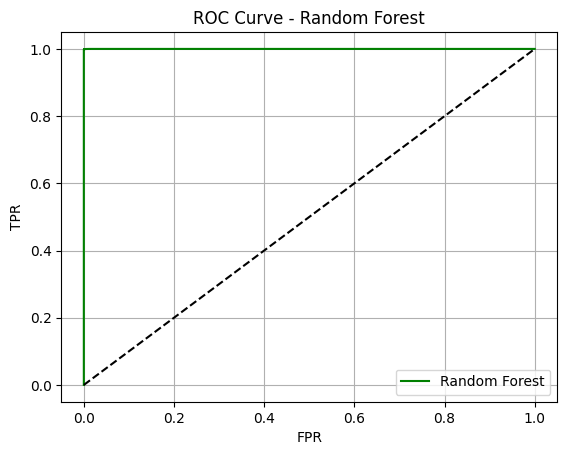

ROC AUC Score (RF): 0.9999960295866368


In [ ]:
y_prob_rf = rf_clf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label='Random Forest', color='green')
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

print("ROC AUC Score (RF):", roc_auc_score(y_test, y_prob_rf))

model to predict how much delay happened

#Feature Selection

In [ ]:
leakage_features = [
     'arr_cancelled','airport', 'carrier', 'carrier_name', 'airport_name',
    'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct','arr_flights','delay'
]

In [ ]:
df_rg=df.drop(columns=leakage_features, axis=1)

In [ ]:
df_rg.head()

,year,month,arr_del15,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,12,5.0,0.0,672.0,61.0,574.0,20.0,0.0,17.0
1,2023,12,7.0,0.0,348.0,252.0,0.0,33.0,0.0,63.0
2,2023,12,10.0,0.0,859.0,536.0,0.0,47.0,0.0,276.0
3,2023,12,2.0,0.0,75.0,9.0,0.0,0.0,0.0,66.0
4,2023,12,256.0,0.0,21424.0,8906.0,732.0,1487.0,0.0,10299.0


In [ ]:

X=df_rg.drop(columns=['arr_delay'])
y=df_rg['arr_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
scaled_features = StandardScaler().fit_transform(X_train, X_test)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:

model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 0.9950893042743375
R^2 Score: 0.9999999929326142


linear regression performed very well

#OAI

In [ ]:
w1 = 2.0
w2 = 2.0

df_rg['OAI'] = w1 * df_rg['carrier_delay'] + w2 * df_rg['late_aircraft_delay']

X = df_rg.drop(['OAI', 'carrier_delay', 'late_aircraft_delay'], axis=1)
y = df_rg['OAI']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("🔍 Mean Squared Error (OAI):", mse)


results = pd.DataFrame({'Actual OAI': y_test.values, 'Predicted OAI': y_pred})
print(results)


🔍 Mean Squared Error (OAI): 5.9701809907793715
       Actual OAI  Predicted OAI
0           360.0     359.992954
1          5088.0    5087.988727
2           532.0     531.990342
3           422.0     421.986762
4           208.0     207.986249
...           ...            ...
35745       128.0     127.981133
35746       288.0     287.981656
35747      4924.0    4923.990214
35748       158.0     157.985388
35749      1510.0    1509.983053

[35750 rows x 2 columns]


In [ ]:
from sklearn.metrics import root_mean_squared_error

In [ ]:
root_mean_squared_error(y_test, y_pred)

2.4433953815908245

#SHAP

In [ ]:
pip install shap


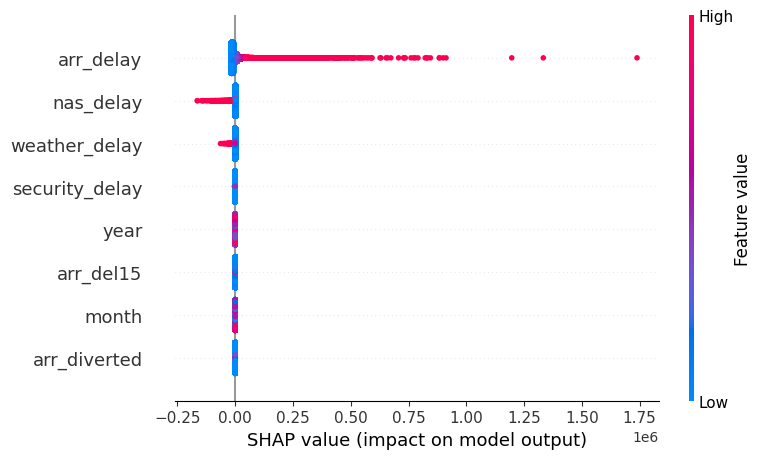

In [ ]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)


controllable_features = ['arr_delay']
external_features = ['weather_delay', 'nas_delay', 'security_delay']


weighted_shap_values = shap_values.values.copy()

feature_names = X_test.columns

for i, feature in enumerate(feature_names):
    if feature in controllable_features:
        weighted_shap_values[:, i] *= 2.0  # more weight
    elif feature in external_features:
        weighted_shap_values[:, i] *= 1.0  # standard weight
    else:
        weighted_shap_values[:, i] *= 1.0  # neutral


shap.summary_plot(weighted_shap_values, X_test, feature_names=feature_names)